# Iluminação global - Ray Tracing



A ideia base dos algortimos de iluminação global é simular o trajeto que os raios de luz percorrem na cena para calcular cores, luzes,  sombras, e outros detalhes de iluminação.
A simulação é feita de maneira inversa, pois os raios são lançados do ponto que representam a câmera em direção à cena, e não dos objetos para câmera.
Através de princípios físicos, podemos simular diversos fenômenos como a iluminação global; materiais reflexivos, difusos e translúcidos que podem refletir e refratar os raios de luz de maneira diferente; sombras, foco e desfoque da câmera (profundidade de campo)...
Algortimos de ray tracing é amplamente utilizado no desenvolvimento de jogos, produção de filmes e simulação de física.

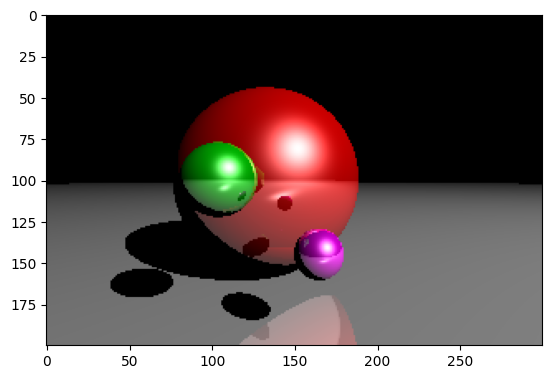

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#normaliza o vetor, com valores entre 0-1
def normalize(vector):
    return vector / np.linalg.norm(vector)

#calcula a reflação do luz
def reflected(vector, axis):
    return vector - 2 * np.dot(vector, axis) * axis

#interseção da luz na esfera
def sphere_intersect(center, radius, ray_origin, ray_direction):
    b = 2 * np.dot(ray_direction, ray_origin - center)
    c = np.linalg.norm(ray_origin - center) ** 2 - radius ** 2
    delta = b ** 2 - 4 * c
    if delta > 0:
        t1 = (-b + np.sqrt(delta)) / 2
        t2 = (-b - np.sqrt(delta)) / 2
        if t1 > 0 and t2 > 0:
            return min(t1, t2)
    return None

#objeto mais proximo interceptado
def nearest_intersected_object(objects, ray_origin, ray_direction):
    distances = [sphere_intersect(obj['center'], obj['radius'], ray_origin, ray_direction) for obj in objects]
    nearest_object = None
    min_distance = np.inf
    for index, distance in enumerate(distances):
        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = objects[index]
    return nearest_object, min_distance

width = 300
height = 200

max_depth = 3

camera = np.array([0, 0, 1])
ratio = float(width) / height
screen = (-1, 1 / ratio, 1, -1 / ratio) # esquerda, em cima, direita, embaixo

light = { 'position': np.array([5, 5, 5]), 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]) }

objects = [
    { 'center': np.array([-0.2, 0, -1]), 'radius': 0.7, 'ambient': np.array([0.1, 0, 0]), 'diffuse': np.array([0.7, 0, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 },
    { 'center': np.array([0.1, -0.3, 0]), 'radius': 0.1, 'ambient': np.array([0.1, 0, 0.1]), 'diffuse': np.array([0.7, 0, 0.7]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 },
    { 'center': np.array([-0.3, 0, 0]), 'radius': 0.15, 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 },
    { 'center': np.array([0, -9000, 0]), 'radius': 9000 - 0.7, 'ambient': np.array([0.1, 0.1, 0.1]), 'diffuse': np.array([0.6, 0.6, 0.6]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }
]

image = np.zeros((height, width, 3))
for i, y in enumerate(np.linspace(screen[1], screen[3], height)):
    for j, x in enumerate(np.linspace(screen[0], screen[2], width)):
        # a tela está na origem
        pixel = np.array([x, y, 0])
        origin = camera
        direction = normalize(pixel - origin)

        color = np.zeros((3))
        reflection = 1

        for k in range(max_depth):
            # verificando as interseções
            nearest_object, min_distance = nearest_intersected_object(objects, origin, direction)
            if nearest_object is None:
                break

            intersection = origin + min_distance * direction
            normal_to_surface = normalize(intersection - nearest_object['center'])
            shifted_point = intersection + 1e-5 * normal_to_surface
            intersection_to_light = normalize(light['position'] - shifted_point)

            _, min_distance = nearest_intersected_object(objects, shifted_point, intersection_to_light)
            intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
            is_shadowed = min_distance < intersection_to_light_distance

            if is_shadowed:
                break

            illumination = np.zeros((3))

            # ambiente
            illumination += nearest_object['ambient'] * light['ambient']

            # difuso
            illumination += nearest_object['diffuse'] * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

            # polimento
            intersection_to_camera = normalize(camera - intersection)
            H = normalize(intersection_to_light + intersection_to_camera)
            illumination += nearest_object['specular'] * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object['shininess'] / 4)

            # reflação
            color += reflection * illumination
            reflection *= nearest_object['reflection']

            origin = shifted_point
            direction = reflected(direction, normal_to_surface)

        image[i, j] = np.clip(color, 0, 1)

plt.imshow(image)

#### Referências

1. https://medium.com/programacaodinamica/o-algoritmo-por-tr%C3%A1s-da-ilumina%C3%A7%C3%A3o-realista-de-filmes-e-jogos-b66a55869514
2. https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9
3. https://developer.nvidia.com/blog/writing-ray-tracing-apps-in-python-using-numba-for-pyoptix/